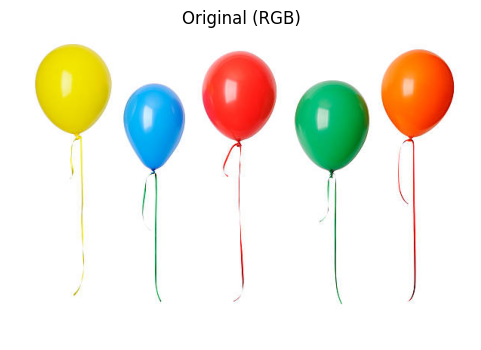

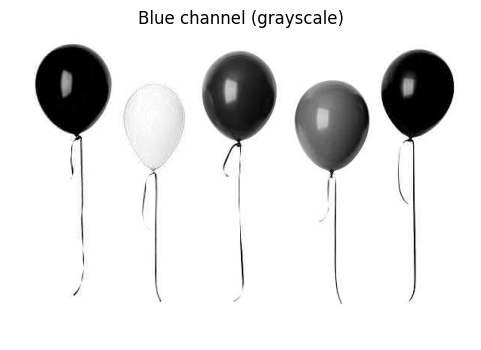

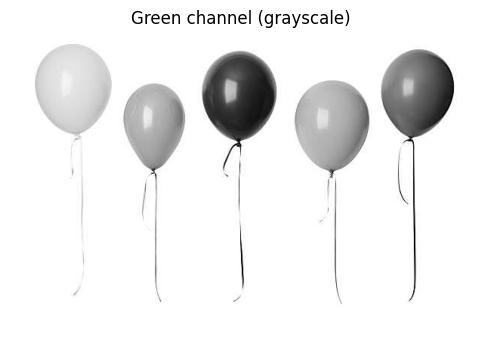

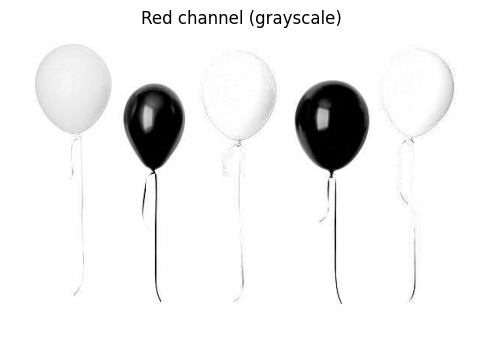

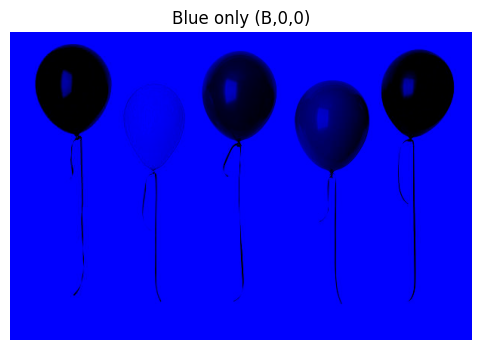

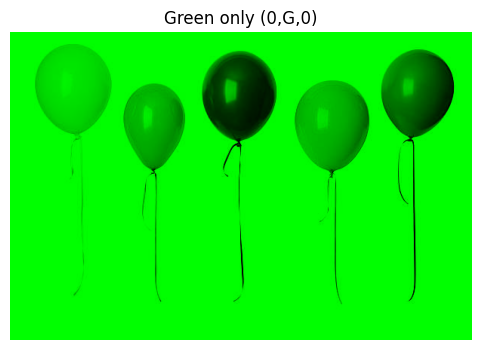

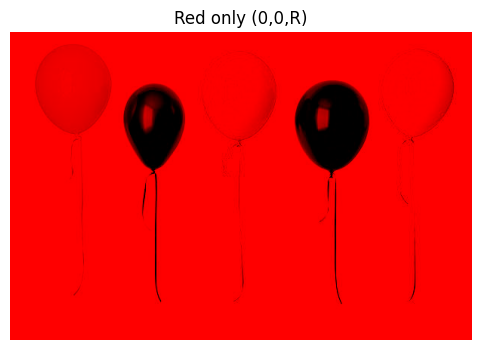

{'B_gray': WindowsPath('balloons_B_gray.png'),
 'G_gray': WindowsPath('balloons_G_gray.png'),
 'R_gray': WindowsPath('balloons_R_gray.png'),
 'B_color': WindowsPath('balloons_B_only.png'),
 'G_color': WindowsPath('balloons_G_only.png'),
 'R_color': WindowsPath('balloons_R_only.png'),
 'original_rgb': WindowsPath('balloons_original_rgb.png')}

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

image_path = Path("lab02_ex.png")
img_bgr = cv2.imread(str(image_path))
if img_bgr is None:
    raise FileNotFoundError(f"Image not found at {image_path}")

# Split into B, G, R channels
b, g, r = cv2.split(img_bgr)

# Save grayscale channel images
out_dir = Path("")
paths = {
    "B_gray": out_dir / "balloons_B_gray.png",
    "G_gray": out_dir / "balloons_G_gray.png",
    "R_gray": out_dir / "balloons_R_gray.png",
    "B_color": out_dir / "balloons_B_only.png",
    "G_color": out_dir / "balloons_G_only.png",
    "R_color": out_dir / "balloons_R_only.png",
    "original_rgb": out_dir / "balloons_original_rgb.png",
}

# Also create colored versions that keep only one channel for visualization
zeros = np.zeros_like(b)
only_b = cv2.merge([b, zeros, zeros])
only_g = cv2.merge([zeros, g, zeros])
only_r = cv2.merge([zeros, zeros, r])

# Save files
cv2.imwrite(str(paths["B_gray"]), b)
cv2.imwrite(str(paths["G_gray"]), g)
cv2.imwrite(str(paths["R_gray"]), r)
cv2.imwrite(str(paths["B_color"]), only_b)
cv2.imwrite(str(paths["G_color"]), only_g)
cv2.imwrite(str(paths["R_color"]), only_r)
cv2.imwrite(str(paths["original_rgb"]), cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))

# Show the original
plt.figure(figsize=(6,4))
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Original (RGB)")
plt.show()

# Show each grayscale channel
for channel_img, title in [(b, "Blue channel (grayscale)"),
                           (g, "Green channel (grayscale)"),
                           (r, "Red channel (grayscale)")]:
    plt.figure(figsize=(6,4))
    plt.imshow(channel_img, cmap="gray")
    plt.axis("off")
    plt.title(title)
    plt.show()

# Show colored versions (only one channel kept)
for channel_img, title in [(only_b, "Blue only (B,0,0)"),
                           (only_g, "Green only (0,G,0)"),
                           (only_r, "Red only (0,0,R)")]:
    plt.figure(figsize=(6,4))
    plt.imshow(cv2.cvtColor(channel_img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title(title)
    plt.show()

paths


Đã tìm 5 quả bóng. Tọa độ (x, y, w, h):
1: (34, 16, 100, 127)
2: (151, 69, 81, 115)
3: (255, 26, 98, 126)
4: (378, 66, 98, 118)
5: (492, 23, 96, 118)


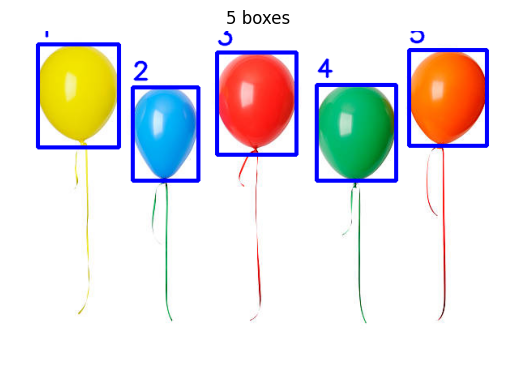

In [ ]:
import cv2
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

# ---- 1) Đọc ảnh ----
image_path = Path("lab02_ex.png")               # đổi nếu bạn để ở thư mục khác
img_bgr = cv2.imread(str(image_path))
if img_bgr is None:
    raise FileNotFoundError(f"Không tìm thấy ảnh: {image_path}")

# ---- 2) Lọc vùng màu (HSV) để loại nền trắng & chữ đen ----
hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)

# Giữ các pixel có độ bão hòa & độ sáng đủ lớn (balloons rất rực)
sat_min, val_min = 80, 80
mask = cv2.inRange(hsv, (0, sat_min, val_min), (179, 255, 255))

# ---- 3) Morphology để khử nhiễu và không dính các quả gần nhau ----
kernel_open  = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
kernel_close = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9, 9))
mask_clean = cv2.morphologyEx(mask, cv2.MORPH_OPEN,  kernel_open,  iterations=1)
mask_clean = cv2.morphologyEx(mask_clean, cv2.MORPH_CLOSE, kernel_close, iterations=1)

# ---- 4) Tìm contour & lọc theo kích thước/khung ----
cnts, _ = cv2.findContours(mask_clean, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
h_img, w_img = mask_clean.shape
min_area = (w_img * h_img) * 0.0015  # loại bỏ mảng nhỏ

boxes = []
for c in cnts:
    x, y, w, h = cv2.boundingRect(c)
    area = w * h
    if area < min_area:
        continue
    # loại vùng quá mỏng/nông (nếu vẫn còn nhiễu), trừ khi nó khá to
    if (h < 0.10 * h_img or w < 0.02 * w_img) and area < (w_img * h_img) * 0.008:
        continue
    boxes.append((x, y, w, h))

# Sắp trái sanng phải cho đẹp
boxes = sorted(boxes, key=lambda b: b[0])

# ---- 5) Vẽ bounding-box ----
vis = img_bgr.copy()
for i, (x, y, w, h) in enumerate(boxes, 1):
    cv2.rectangle(vis, (x, y), (x+w, y+h), (255, 0, 0), 3)
    cv2.putText(vis, str(i), (x, max(0, y-10)),
                cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255, 0, 0), 2, cv2.LINE_AA)

# Lưu & hiển thị
out_path = image_path.parent / "balloons_bounding_boxes.png"
cv2.imwrite(str(out_path), vis)

print(f"Đã tìm {len(boxes)} quả bóng. Tọa độ (x, y, w, h):")
for i, b in enumerate(boxes, 1):
    print(f"{i}: {b}")
plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB)); plt.axis("off"); plt.title(f"{len(boxes)} boxes"); plt.show()


Đã tìm 5 quả bóng. Tọa độ (x,y,w,h):
1: (34, 16, 100, 127)
2: (151, 69, 81, 115)
3: (255, 26, 98, 126)
4: (378, 66, 98, 118)
5: (492, 23, 96, 118)
Nhãn: ['yellow', 'blue', 'red', 'green', 'orange']


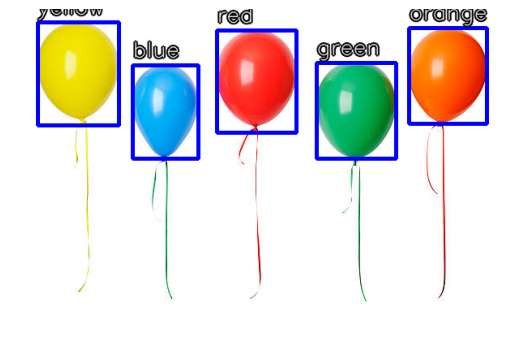

In [8]:
import cv2
import numpy as np
from pathlib import Path

# ---- Load image ----
image_path = Path("lab02_ex.png")   # đổi nếu lưu chỗ khác
img = cv2.imread(str(image_path))
if img is None:
    raise FileNotFoundError(f"Không tìm thấy ảnh: {image_path}")

# ---- Detect balloons (HSV + morphology) ----
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
mask = cv2.inRange(hsv, (0, 80, 80), (179, 255, 255))  # giữ vùng đủ bão hòa & sáng

openK  = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
closeK = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9, 9))
m = cv2.morphologyEx(mask, cv2.MORPH_OPEN,  openK,  iterations=1)
m = cv2.morphologyEx(m,    cv2.MORPH_CLOSE, closeK, iterations=1)

cnts, _ = cv2.findContours(m, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
H, W = m.shape
min_area = 0.0015 * W * H

boxes = []
for c in cnts:
    x, y, w, h = cv2.boundingRect(c)
    if w * h < min_area:
        continue
    if (h < 0.10 * H or w < 0.02 * W) and (w * h < 0.008 * W * H):
        continue
    boxes.append((x, y, w, h))

boxes = sorted(boxes, key=lambda b: b[0])  # trái → phải

# ---- Simple color labeling by dominant hue ----
def name_from_h(h):
    if h < 10 or h >= 170: return "red"
    if 10 <= h < 20:       return "orange"
    if 20 <= h < 35:       return "yellow"
    if 35 <= h < 85:       return "green"
    if 85 <= h < 135:      return "blue"
    return "unknown"

labels = []
for (x, y, w, h) in boxes:
    crop_hsv  = hsv[y:y+h, x:x+w]
    crop_mask = m[y:y+h, x:x+w]
    hs = crop_hsv[..., 0][crop_mask > 0]

    if hs.size == 0:
        # fallback trung tâm nếu mask rỗng
        hue = int(hsv[y + h // 2, x + w // 2, 0])
    else:
        # --- FIX: dùng flatten trước argmax để tránh DeprecationWarning ---
        hist = cv2.calcHist([hs.astype(np.uint8)], [0], None, [180], [0, 180]).flatten()
        hue = int(np.argmax(hist))

    labels.append(name_from_h(hue))

# ---- Draw & save ----
vis = img.copy()
for (x, y, w, h), name in zip(boxes, labels):
    cv2.rectangle(vis, (x, y), (x + w, y + h), (255, 0, 0), 3)
    org = (x, max(0, y - 10))
    cv2.putText(vis, name, org, cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 0), 3, cv2.LINE_AA)
    cv2.putText(vis, name, org, cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 255, 255), 1, cv2.LINE_AA)

cv2.imwrite("balloons_labeled.png", vis)

print(f"Đã tìm {len(boxes)} quả bóng. Tọa độ (x,y,w,h):")
for i, b in enumerate(boxes, 1):
    print(f"{i}: {b}")
print("Nhãn:", labels)

import matplotlib.pyplot as plt; 
plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB)); plt.axis('off'); plt.show()



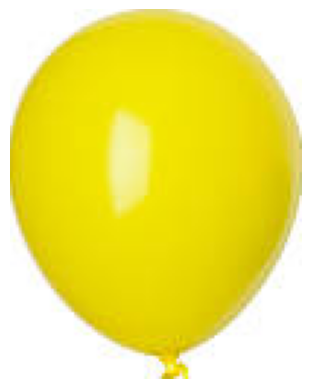

In [9]:
import cv2
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

# ---- 1) Đọc ảnh ----
image_path = Path("lab02_ex.png")   # đổi đường dẫn nếu cần
img = cv2.imread(str(image_path))
if img is None:
    raise FileNotFoundError(f"Không tìm thấy ảnh: {image_path}")

# ---- 2) Tạo mask vùng màu & làm sạch (giống câu 2, gọn) ----
hsv  = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
mask = cv2.inRange(hsv, (0, 80, 80), (179, 255, 255))
openK  = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
closeK = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9,9))
m = cv2.morphologyEx(mask, cv2.MORPH_OPEN,  openK)
m = cv2.morphologyEx(m,    cv2.MORPH_CLOSE, closeK)

# ---- 3) Tìm contour & lấy các bounding boxes ----
cnts, _ = cv2.findContours(m, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
H, W = m.shape
boxes = []
for c in cnts:
    x, y, w, h = cv2.boundingRect(c)
    if w*h > 0.0015*W*H:
        boxes.append((x, y, w, h))

# Sắp trái→phải; bóng vàng là box đầu tiên
boxes = sorted(boxes, key=lambda b: b[0])
x, y, w, h = boxes[0]

# ---- 4) Cắt ROI của bóng vàng và lưu ----
yellow_roi = img[y:y+h, x:x+w]                       # ảnh cắt gọn
cv2.imwrite("yellow_balloon_roi.png", yellow_roi)

# (tuỳ chọn) Ảnh full-size nhưng chỉ để lại ROI, nền đen:
yellow_on_black = np.zeros_like(img)
yellow_on_black[y:y+h, x:x+w] = yellow_roi
cv2.imwrite("yellow_balloon_full_black.png", yellow_on_black)

# ---- 5) In ảnh ra màn hình (Jupyter/Colab) ----
import matplotlib.pyplot as plt
plt.imshow(cv2.cvtColor(yellow_roi, cv2.COLOR_BGR2RGB)); plt.axis('off'); plt.show()

# Nếu chạy app desktop có GUI, dùng 1 dòng này thay cho matplotlib:
# cv2.imshow("yellow_roi", yellow_roi); cv2.waitKey(0); cv2.destroyAllWindows()


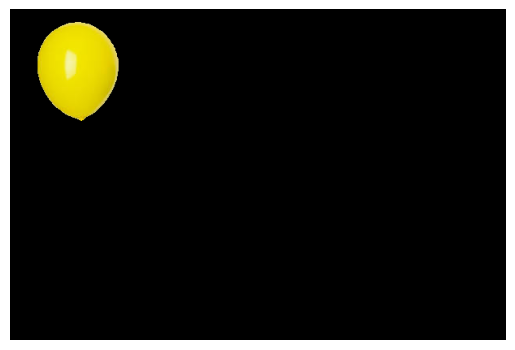

In [10]:
import cv2, numpy as np, matplotlib.pyplot as plt
from pathlib import Path

img = cv2.imread("lab02_ex.png")
if img is None:
    raise FileNotFoundError("Không tìm thấy ảnh lab02_ex.png")

# 1) BGR -> HSV
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

# 2) Ngưỡng màu VÀNG (có thể chỉnh nhẹ nếu ảnh khác)
lower_yellow = (20, 90, 90)   # H,S,V
upper_yellow = (35, 255, 255)
mask = cv2.inRange(hsv, lower_yellow, upper_yellow)

# 3) Morphology để khử nhiễu/khép kín
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7,7))
mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN,  kernel, iterations=1)
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=1)

# 4) Lấy contour lớn nhất (giả sử chỉ có 1 bóng vàng) + bbox
annot = img.copy()
cnts, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
if cnts:
    c = max(cnts, key=cv2.contourArea)
    x,y,w,h = cv2.boundingRect(c)
    cv2.rectangle(annot, (x,y), (x+w, y+h), (0,0,255), 3)
    cv2.putText(annot, "yellow", (x, max(0, y-10)),
                cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0,0,0), 3, cv2.LINE_AA)
    cv2.putText(annot, "yellow", (x, max(0, y-10)),
                cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255,255,255), 1, cv2.LINE_AA)

# 5) Giữ lại chỉ vùng vàng
yellow_only = cv2.bitwise_and(img, img, mask=mask)

# Lưu & hiển thị (1 lệnh Matplotlib)
cv2.imwrite("q5_yellow_mask.png", mask)
cv2.imwrite("q5_yellow_only.png", yellow_only)
cv2.imwrite("q5_yellow_annotated.png", annot)

import matplotlib.pyplot as plt
plt.imshow(cv2.cvtColor(yellow_only, cv2.COLOR_BGR2RGB)); plt.axis("off"); plt.show()
# Nếu chạy desktop GUI: cv2.imshow("yellow", yellow_only); cv2.waitKey(0); cv2.destroyAllWindows()


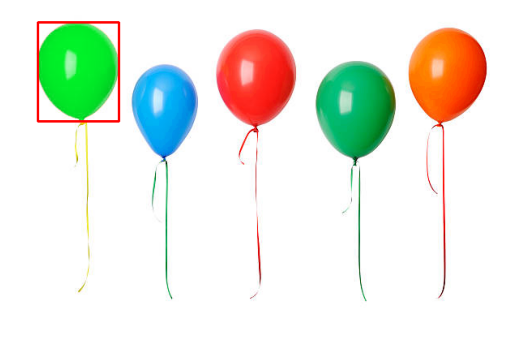

In [11]:
import cv2
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

# ========= CONFIG =========
IMAGE = "lab02_ex.png"        # đổi nếu ảnh ở nơi khác
OUT_DIR = Path(".")           # thư mục lưu kết quả
# ==========================

# 1) Đọc ảnh
img = cv2.imread(IMAGE)
if img is None:
    raise FileNotFoundError(f"Không tìm thấy '{IMAGE}'")

# 2) BGR -> HSV và tạo mask màu vàng
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
lower_yellow = np.array([20, 90, 90],  dtype=np.uint8)   # H,S,V (OpenCV Hue: 0..179)
upper_yellow = np.array([35, 255, 255], dtype=np.uint8)
mask = cv2.inRange(hsv, lower_yellow, upper_yellow)

# 3) Morphology làm sạch mask
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN,  kernel, iterations=1)
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=1)

# 4) Đổi màu: đổi Hue sang xanh lá, giữ nguyên Saturation & Value
hsv2 = hsv.copy()
hsv2[..., 0][mask > 0] = 65  # ~green (OpenCV hue)
result = cv2.cvtColor(hsv2, cv2.COLOR_HSV2BGR)

# (Tuỳ chọn) tô phẳng xanh lá để so sánh
flat = img.copy()
flat[mask > 0] = (0, 255, 0)

# (Tuỳ chọn) vẽ bbox quanh bóng vàng để kiểm tra
cnts, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
if cnts:
    c = max(cnts, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(c)
    cv2.rectangle(result, (x, y), (x + w, y + h), (0, 0, 255), 2)

# 5) Lưu kết quả
cv2.imwrite(str(OUT_DIR / "q6_yellow_mask_used.png"), mask)
cv2.imwrite(str(OUT_DIR / "q6_repaint_green_hsv_preserve_sv.png"), result)
cv2.imwrite(str(OUT_DIR / "q6_repaint_green_flat.png"), flat)

# 6) Hiển thị ảnh kết quả (Jupyter/Colab)
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB)); plt.axis("off"); plt.show()
# Nếu chạy desktop có GUI:
# cv2.imshow("repaint", result); cv2.waitKey(0); cv2.destroyAllWindows()


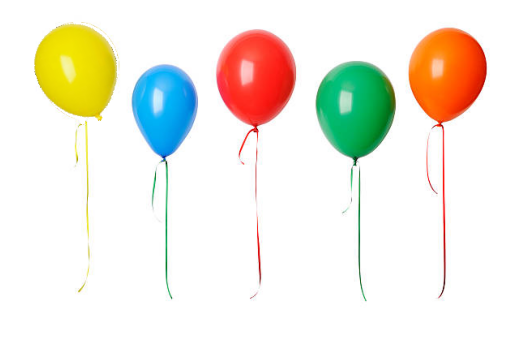

In [12]:
import cv2
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

# ========= CONFIG =========
IMAGE = "lab02_ex.png"        # đổi nếu ảnh ở nơi khác
ANGLE = 20                    # +20° (ngược chiều kim đồng hồ)
OUT = Path(".")
# ==========================

# 1) Đọc ảnh
img = cv2.imread(IMAGE)
if img is None:
    raise FileNotFoundError(f"Không tìm thấy '{IMAGE}'")

# 2) Mask vùng có màu (để tìm tất cả bóng)
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
mask = cv2.inRange(hsv, (0, 80, 80), (179, 255, 255))

openK  = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
closeK = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9,9))
m = cv2.morphologyEx(mask, cv2.MORPH_OPEN,  openK)
m = cv2.morphologyEx(m,    cv2.MORPH_CLOSE, closeK)

# 3) Lấy bounding boxes và chọn bóng TRÁI NHẤT (bóng #1)
cnts, _ = cv2.findContours(m, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
H, W = m.shape
boxes = []
for c in cnts:
    x, y, w, h = cv2.boundingRect(c)
    if w*h > 0.0015*W*H:     # loại nhiễu nhỏ
        boxes.append((x,y,w,h))
if not boxes:
    raise RuntimeError("Không tìm được bóng nào.")
boxes = sorted(boxes, key=lambda b: b[0])  # trái→phải
x, y, w, h = boxes[0]

# 4) ROI của bóng #1 và mask trong ROI
roi = img[y:y+h, x:x+w]
roi_mask = m[y:y+h, x:x+w]               # nhị phân: 255 là bóng, 0 là nền

# 5) Hàm xoay không cắt mất cạnh (rotate bound) cho cả ảnh ROI & mask
def rotate_image_and_mask(im, mk, angle):
    (h2, w2) = im.shape[:2]
    cX, cY = w2 // 2, h2 // 2
    M = cv2.getRotationMatrix2D((cX, cY), angle, 1.0)
    cos, sin = abs(M[0,0]), abs(M[0,1])
    nW = int((h2 * sin) + (w2 * cos))
    nH = int((h2 * cos) + (w2 * sin))
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY
    rot_im = cv2.warpAffine(im, M, (nW, nH), flags=cv2.INTER_LINEAR,  borderValue=(0,0,0))
    rot_mk = cv2.warpAffine(mk, M, (nW, nH), flags=cv2.INTER_NEAREST, borderValue=0)
    return rot_im, rot_mk

rot_roi, rot_mask = rotate_image_and_mask(roi, roi_mask, ANGLE)

# 6) Ghép lại vào ảnh gốc: đặt tâm như cũ
cx, cy = x + w//2, y + h//2
hR, wR = rot_roi.shape[:2]
x_new, y_new = cx - wR//2, cy - hR//2

# Cắt để không vượt biên
x0 = max(0, x_new); y0 = max(0, y_new)
x1 = min(W, x_new + wR); y1 = min(H, y_new + hR)
rx0, ry0 = x0 - x_new, y0 - y_new
rx1, ry1 = rx0 + (x1 - x0), ry0 + (y1 - y0)

rot_roi_c  = rot_roi[ry0:ry1, rx0:rx1]
rot_mask_c = rot_mask[ry0:ry1, rx0:rx1]

# 6a) Xoá quả bóng gốc (đổ nền trắng tại vùng bóng #1 cũ)
result = img.copy()
result[y:y+h, x:x+w][roi_mask > 0] = (255, 255, 255)

# 6b) Dán bóng đã xoay bằng mask
inv = cv2.bitwise_not(rot_mask_c)
bg = cv2.bitwise_and(result[y0:y1, x0:x1], result[y0:y1, x0:x1], mask=inv)
fg = cv2.bitwise_and(rot_roi_c, rot_roi_c, mask=rot_mask_c)
result[y0:y1, x0:x1] = cv2.add(bg, fg)

# 7) Lưu & hiển thị
cv2.imwrite(str(OUT / "q7_rotate_first_balloon_20deg.png"), result)
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB)); plt.axis("off"); plt.show()
# Nếu chạy desktop GUI:
# cv2.imshow("q7", result); cv2.waitKey(0); cv2.destroyAllWindows()
